In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [30]:
DATASET_PATH = './data/beer_profile_and_ratings.csv'
TARGET_COLUMN = 'review_overall'

NUMERICAL_FEATURES = ['ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']
CATEGORICAL_FEATURES = ['Style']

TEST_SIZE = 0.2
RANDOM_STATE = 42

In [31]:
df = pd.read_table(DATASET_PATH, delimiter=',')
def trim_style(style):
    if '-' in style:
        return style.split('-')[0].strip()
    return style

df['Style'] = df['Style'].apply(trim_style)
unique_styles = df['Style'].unique()

# df.head()
# df.info()

In [32]:
from scipy.stats import chi2

numeric_features = ['ABV', 'Min IBU', 'Max IBU']

def mahalanobis_dist(df, features):
    X = df[features].values
    mean = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        cov_inv = np.linalg.pinv(cov)  # Используем псевдообратную матрицу если обычная вырождена
    
    deviations = X - mean
    distances = np.sqrt(np.sum(deviations.dot(cov_inv) * deviations, axis=1))
    return distances

# Вычисляем расстояния
distances = mahalanobis_dist(df, numeric_features)

threshold = chi2.ppf(0.95, df=len(numeric_features))  # 95% доверительный интервал

outliers_mask = distances > np.sqrt(threshold)
outliers = df[outliers_mask]

original_size = len(df)
df_clean = df[~outliers_mask]

df = df_clean.copy()

In [33]:
print("\n1.1 Анализ пропущенных значений")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Количество': missing_values, 'Процент': missing_percent})

# Оставляем только столбцы с пропусками и сортируем по убыванию процента
missing_df = missing_df[missing_df['Количество'] > 0].sort_values(by='Процент', ascending=False)
print("Столбцы с пропущенными значениями:")
print(missing_df)


1.1 Анализ пропущенных значений
Столбцы с пропущенными значениями:
Empty DataFrame
Columns: [Количество, Процент]
Index: []


In [34]:
selected_columns = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
all_columns_for_X = selected_columns
X = df[all_columns_for_X].copy() # Матрица признаков
y = df[TARGET_COLUMN].copy()   # Вектор целевой переменной

print(f"\nВыбранные признаки (X): {list(X.columns)}")
print(f"Целевая переменная (y): {TARGET_COLUMN}")
print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")


Выбранные признаки (X): ['ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'Style']
Целевая переменная (y): review_overall
Размер X: (2951, 19)
Размер y: (2951,)


In [35]:
print(f"\nРазделение данных на обучающую и тестовую выборки (Доля тестовой: {TEST_SIZE}, Random State: {RANDOM_STATE})")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f"Размер X_train: {X_train.shape}")
print(f"Размер X_test: {X_test.shape}")
print(f"Размер y_train: {y_train.shape}")
print(f"Размер y_test: {y_test.shape}")


Разделение данных на обучающую и тестовую выборки (Доля тестовой: 0.2, Random State: 42)
Размер X_train: (2360, 19)
Размер X_test: (591, 19)
Размер y_train: (2360,)
Размер y_test: (591,)


In [36]:
print("\nОпределение шагов предобработки для числовых и категориальных признаков")

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
print("\nШаги пайплайна для числовых признаков:")
print(numerical_pipeline)

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
print("\nШаги пайплайна для категориальных признаков:")
print(categorical_pipeline)


Определение шагов предобработки для числовых и категориальных признаков

Шаги пайплайна для числовых признаков:
Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

Шаги пайплайна для категориальных признаков:
Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])


In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, NUMERICAL_FEATURES),
        ('cat', categorical_pipeline, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough'
)
print("\nСоздан ColumnTransformer:")
print(preprocessor)


Создан ColumnTransformer:
ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['ABV', 'Min IBU', 'Max IBU', 'Astringency',
                                  'Body', 'Alcohol', 'Bitter', 'Sweet', 'Sour',
                                  'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty',
                                  'review_aroma', 'review_appearance',
                                  'review_palate', 'review_taste']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
         

In [38]:
X_train_processed = preprocessor.fit_transform(X_train)
print(f"Размер обработанных обучающих данных: {X_train_processed.shape}")

X_test_processed = preprocessor.transform(X_test)
print(f"Размер обработанных тестовых данных: {X_test_processed.shape}")

# Проверка обработанных данных
try:
    feature_names_out = preprocessor.get_feature_names_out()
    X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_out, index=X_train.index)
    print("Проверка на NaN в обработанных обучающих данных:", X_train_processed_df.isnull().sum().sum())
except AttributeError:
    print("Проверка на NaN в обработанном X_train (NumPy):", np.isnan(X_train_processed).sum())

Размер обработанных обучающих данных: (2360, 59)
Размер обработанных тестовых данных: (591, 59)
Проверка на NaN в обработанных обучающих данных: 0


In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Обучение модели (Линейная Регрессия)
model = LinearRegression()
model.fit(X_train_processed, y_train)

# Получение предсказаний
y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)

# Оценка качества модели
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\n--- Метрики на ОБУЧАЮЩЕЙ выборке ---")
print(f"Mean Absolute Error (MAE): {mae_train:.4f}")
# print(f"Mean Squared Error (MSE): {mse_train:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_train:.4f}")
print(f"R-squared (R²): {r2_train:.4f}")
print(f"(R² показывает долю дисперсии целевой переменной, объясненную моделью. Ближе к 1 - лучше.)")

print("\n--- Метрики на ТЕСТОВОЙ выборке ---")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
# print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f"R-squared (R²): {r2_test:.4f}")

print("\n--- Сравнение R² ---")
print(f"R² (Обучающая): {r2_train:.4f}")
print(f"R² (Тестовая):   {r2_test:.4f}")

print(f"\nМодель на тестовой выборке объясняет примерно {r2_test*100:.1f}% вариативности общего рейтинга пива.")
print(f"В среднем модель ошибается на {mae_test:.2f} пункта рейтинга на тестовой выборке.")


--- Метрики на ОБУЧАЮЩЕЙ выборке ---
Mean Absolute Error (MAE): 0.0801
Root Mean Squared Error (RMSE): 0.1186
R-squared (R²): 0.9273
(R² показывает долю дисперсии целевой переменной, объясненную моделью. Ближе к 1 - лучше.)

--- Метрики на ТЕСТОВОЙ выборке ---
Mean Absolute Error (MAE): 0.0804
Root Mean Squared Error (RMSE): 0.1274
R-squared (R²): 0.9309

--- Сравнение R² ---
R² (Обучающая): 0.9273
R² (Тестовая):   0.9309

Модель на тестовой выборке объясняет примерно 93.1% вариативности общего рейтинга пива.
В среднем модель ошибается на 0.08 пункта рейтинга на тестовой выборке.


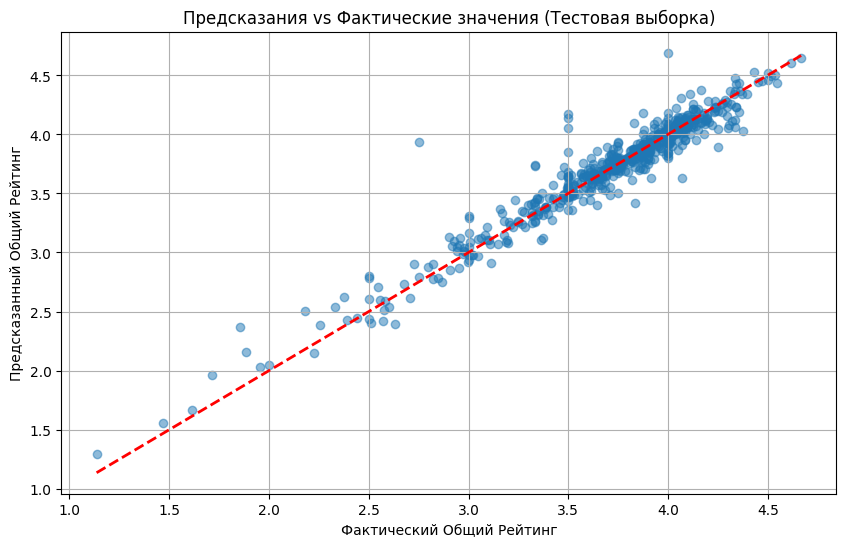

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Фактический Общий Рейтинг')
plt.ylabel('Предсказанный Общий Рейтинг')
plt.title('Предсказания vs Фактические значения (Тестовая выборка)')
plt.grid(True)
plt.show()